In [21]:
import sys
import platform

print(sys.version)
print(platform.processor())

3.8.3 (default, Jun  9 2020, 01:17:07) 
[GCC 9.3.0]
x86_64


# Performance
Посмотрим на производительность в зависимости от прааметров, качество будем смотреть на эталонах

In [22]:
from collections import defaultdict
from time import time

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style("darkgrid")
pd.options.display.float_format = '{:.2f}'.format


def draw_x_y(frames, labels, x, y):
    for i in range(len(frames)):
        plt.scatter(frames[i][x], frames[i][y], s=1, marker='.', label=labels[i])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid('both')
    plt.legend()
    plt.show()

    
def draw_i_y(frames, labels, y):
    for i in range(len(frames)):
        plt.scatter(frames[i].index, frames[i][y], s=1, marker='.', label=labels[i])
    plt.xlabel('iteration')
    plt.ylabel(y)
    plt.grid('both')
    plt.legend()
    plt.show()

# Local Searchers
Сравнения метаэвристик поиска

In [3]:
from lin_kernighan.algorithms.structures.matrix import adjacency_matrix
from lin_kernighan.algorithms.utils.generator import generator
from lin_kernighan.utils import draw_tour

from lin_kernighan.lkh_search import LKHSearch
from lin_kernighan.tabu_search import TabuSearch

In [4]:
def one_test(search, size, iterations, swap=2, draw=False, **kwargs):
    tsp = generator(size)
    matrix = adjacency_matrix(tsp)
    searcher = search(matrix=matrix, collect=True, **kwargs)
    searcher.optimize(iterations=iterations, swap=swap)
    frame = searcher.collector.as_frame()
    frame['time'] = frame['time'] - frame['time'][1]
    frame = frame[1:]
    draw_x_y([frame], [f'{len(tsp)}'], 'time', 'length')
    if draw:
        draw_tour(searcher.tour, tsp)
        
def executor(search, tests, parameter, values, iterations, swap=2):
    frame = defaultdict(list)
    for test in tests:
        tsp = generator(test)
        matrix = adjacency_matrix(tsp)
        for value in values:
            kwargs = {parameter: value}
            t_start = time()
            searcher = search(matrix=matrix, **kwargs)
            searcher.optimize(iterations=iterations, swap=swap)
            frame[f'{value}-time'].append(time() - t_start)
            frame[f'{value}-length'].append(searcher.length)
    print(pd.DataFrame(frame))
    
def performance(search, start, stop, step, iterations=25, tries=5, swap=2, **kwargs):
    frame = defaultdict(list)
    for size in range(start, stop + 1, step):
        for _ in range(iterations):
            tsp = generator(size)
            matrix = adjacency_matrix(tsp)
            t_start = time()
            searcher = search(matrix=matrix, **kwargs)
            searcher.optimize(iterations=tries, swap=swap)
            frame['time'].append((time() - t_start) / tries)
            frame['size'].append(size)
        
    frame = pd.DataFrame(frame)
    return frame

## LKH Search

### General View
Общий вид сходимости, просто посмотрим как внутри сходится в зависимости от типа перезапуска 

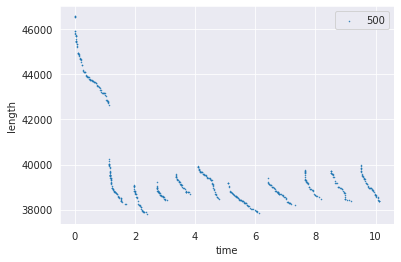

In [47]:
one_test(LKHSearch, 500, 10, init='fast_helsgaun')

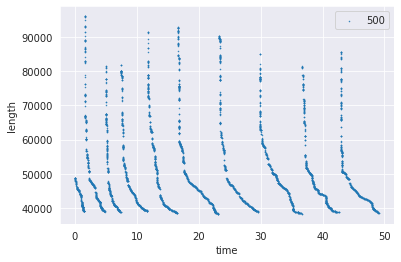

In [48]:
one_test(LKHSearch, 500, 10, init='helsgaun')

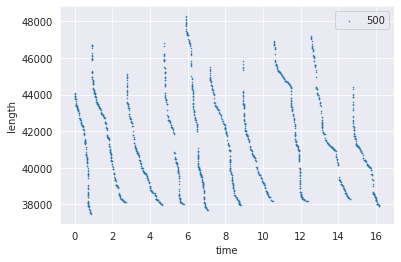

In [50]:
one_test(LKHSearch, 500, 10, init='greedy')

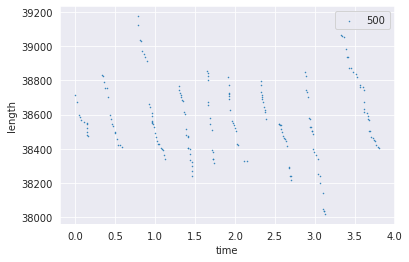

In [51]:
one_test(LKHSearch, 500, 10, init='two_opt', two_opt=True)

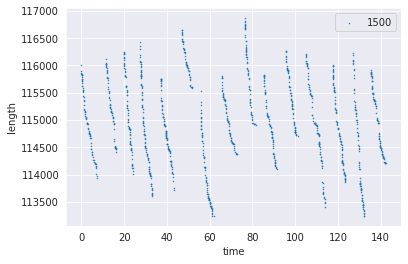

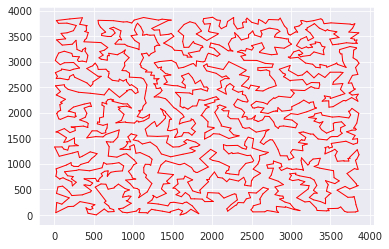

In [5]:
one_test(LKHSearch, 1500, 15, init='two_opt', two_opt=True, draw=True)

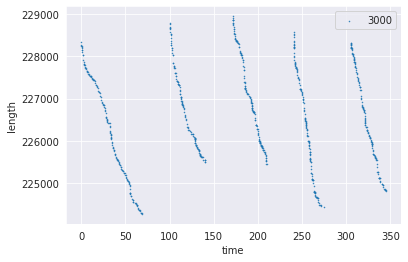

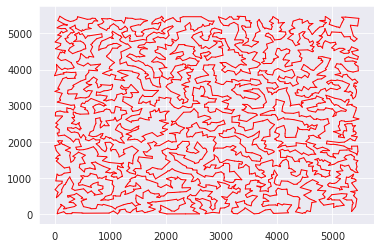

In [6]:
one_test(LKHSearch, 3000, 5, init='two_opt', two_opt=True, draw=True)

### DLB
Использование Don't look bits

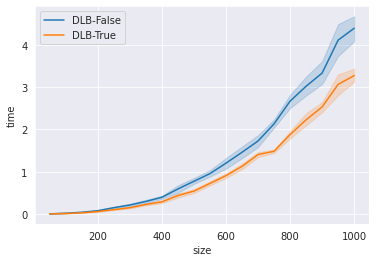

In [48]:
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/LKH-S-DLB/LKH-S-50-1000-50-10-false.csv'), label='DLB-False')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/LKH-S-DLB/LKH-S-50-1000-50-10-true.csv'), label='DLB-True')

## Tabu Search

### General View
Общий вид сходимости в зависимости от типа используемой эвристики

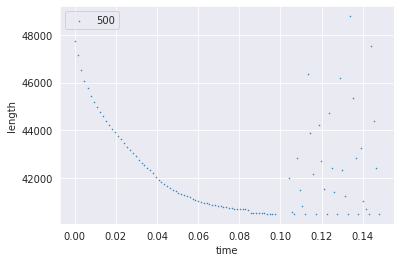

In [7]:
one_test(TabuSearch, 500, 10, swap=2, opt='two_opt')

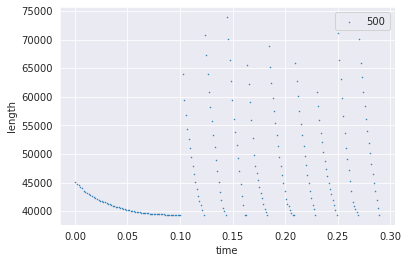

In [8]:
one_test(TabuSearch, 500, 10, swap=8, opt='two_opt')

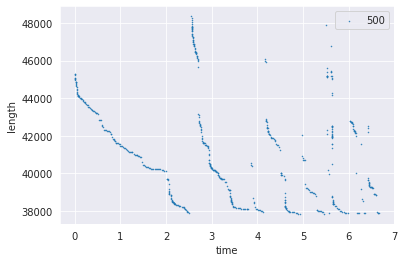

In [9]:
one_test(TabuSearch, 500, 10, swap=2, opt='lk_opt')

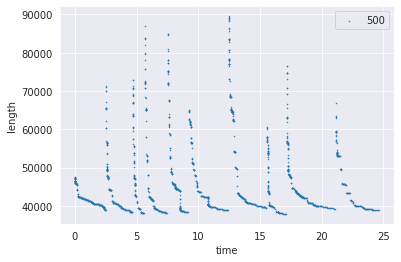

In [10]:
one_test(TabuSearch, 500, 10, swap=8, opt='lk_opt')

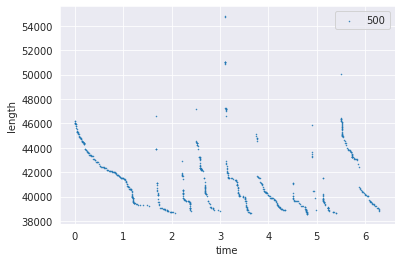

In [11]:
one_test(TabuSearch, 500, 10, swap=2, opt='lkh_opt')

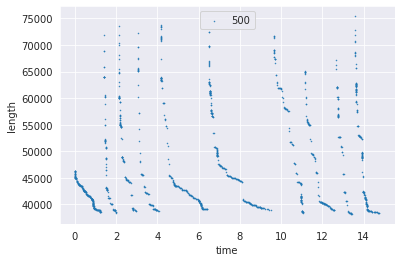

In [12]:
one_test(TabuSearch, 500, 10, swap=8, opt='lkh_opt')

### Swap
В зависимости от количества swap (обмена точек)

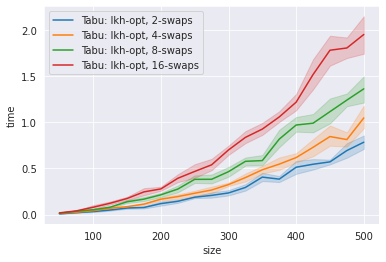

In [49]:
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/Tabu-S-LKH-Swaps/Tabu-S-lkh_opt-50-500-10-10-2.csv'), label='Tabu: lkh-opt, 2-swaps')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/Tabu-S-LKH-Swaps/Tabu-S-lkh_opt-50-500-10-10-4.csv'), label='Tabu: lkh-opt, 4-swaps')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/Tabu-S-LKH-Swaps/Tabu-S-lkh_opt-50-500-10-10-8.csv'), label='Tabu: lkh-opt, 8-swaps')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/Tabu-S-LKH-Swaps/Tabu-S-lkh_opt-50-500-10-10-16.csv'), label='Tabu: lkh-opt, 16-swaps')

## Perfomance

### Одна попытка
Одна итерация эвристики, здесь сильно влияют проблемы первого запуска

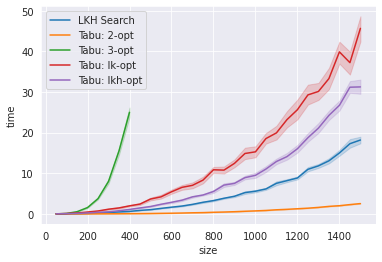

In [50]:
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/One-Try/LKH-S-50-1500-50.csv'), label='LKH Search')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/One-Try/Tabu-S-two_opt-2-50-3000-50-1.csv')[:750], label='Tabu: 2-opt')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/One-Try/Tabu-S-three_opt-50-500-50-1.csv')[:75], label='Tabu: 3-opt')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/One-Try/Tabu-S-lk_opt-50-1500-50-1.csv'), label='Tabu: lk-opt')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/One-Try/Tabu-S-lkh_opt-50-1500-50-1.csv'), label='Tabu: lkh-opt')

### Десять попыток
10 попыток, разные используемые эвристики, у табу разное кол-во swap

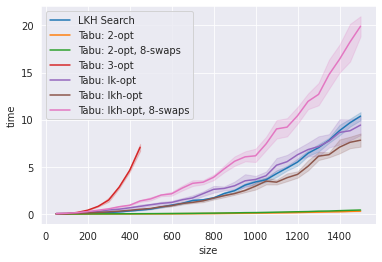

In [18]:
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/Ten-Tries/LKH-S-50-1500-50-10.csv'), label='LKH Search')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/Ten-Tries/Tabu-S-two_opt-50-1500-50-10-2.csv'), label='Tabu: 2-opt')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/Ten-Tries/Tabu-S-two_opt-50-1500-50-10-8.csv'), label='Tabu: 2-opt, 8-swaps')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/Ten-Tries/Tabu-S-three_opt-50-450-50-10-2.csv'), label='Tabu: 3-opt')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/Ten-Tries/Tabu-S-lk_opt-50-1500-50-10-2.csv'), label='Tabu: lk-opt')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/Ten-Tries/Tabu-S-lkh_opt-50-1500-50-10-2.csv'), label='Tabu: lkh-opt')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/Ten-Tries/Tabu-S-lkh_opt-50-1500-50-10-8.csv'), label='Tabu: lkh-opt, 8-swaps')

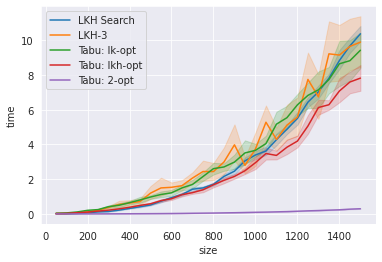

In [44]:
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/Ten-Tries/LKH-S-50-1500-50-10.csv'), label='LKH Search')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/lkh.csv'), label='LKH-3')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/Ten-Tries/Tabu-S-lk_opt-50-1500-50-10-2.csv'), label='Tabu: lk-opt')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/Ten-Tries/Tabu-S-lkh_opt-50-1500-50-10-2.csv'), label='Tabu: lkh-opt')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/Ten-Tries/Tabu-S-two_opt-50-1500-50-10-2.csv'), label='Tabu: 2-opt')

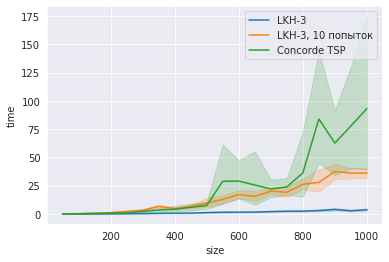

In [47]:
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/lkh.csv')[:300], label='LKH-3')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/lkh_10.csv'), label='LKH-3, 10 попыток')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/concorde.csv'), label='Concorde TSP')

# Local optimization algorithms

In [5]:
from lin_kernighan.algorithms.two_opt import TwoOpt
from lin_kernighan.algorithms.three_opt import ThreeOpt
from lin_kernighan.algorithms.lk_opt import LKOpt
from lin_kernighan.algorithms.lkh_opt import LKHOpt

from lin_kernighan.algorithms.structures.matrix import adjacency_matrix
from lin_kernighan.algorithms.utils.generator import generator
from lin_kernighan.algorithms.utils.initial_tour import greedy

In [6]:
def generate_data(size, tries):
    data = []
    for _ in range(tries):
        tsp = generator(size)
        matrix = adjacency_matrix(tsp)
        length, tour = greedy(matrix)
        data.append((length, tour, matrix))
    return data


def one_test(size, three=False):
    data = generate_data(size, 1)
    two_opt = generate_results(TwoOpt, data)
    lk_opt = generate_results(LKOpt, data)
    lkh_opt = generate_results(LKHOpt, data)
    if three:
        three_opt = generate_results(ThreeOpt, data)

    opts = [two_opt, lk_opt, lkh_opt, three_opt] if three else [two_opt, lk_opt, lkh_opt]
    names = [f"two_opt {two_opt['length'].min():0.1f}", 
             f"lk_opt {lk_opt['length'].min():0.1f}", 
             f"lkh_opt {lkh_opt['length'].min():0.1f}"]
    if three:
        names.append(f"three_opt {three_opt['length'].min():0.1f}")

    draw_x_y(opts, names, 'time', 'length')

    
def generate_results(optimizer, data, **kwargs):
    all_frames = None
    for length, tour, matrix in data:
        opt = optimizer(length, tour.copy(), matrix.copy(), collect=True, **kwargs)
        opt.optimize()

        frame = opt.collector.as_frame()
        frame['time'] = frame['time'] - frame['time'][1]
        frame = frame[1:]
        if all_frames is None:
            all_frames = frame
        else:
            all_frames = all_frames.append(frame)
    return all_frames

## General view for all optimizations
Вид сходимости

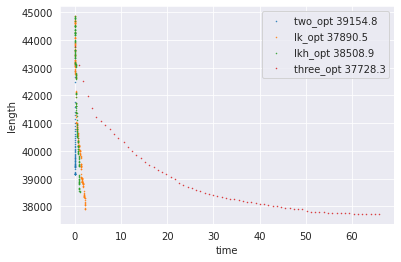

In [7]:
one_test(500, True)

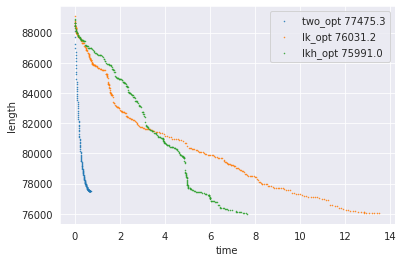

In [8]:
one_test(1000)

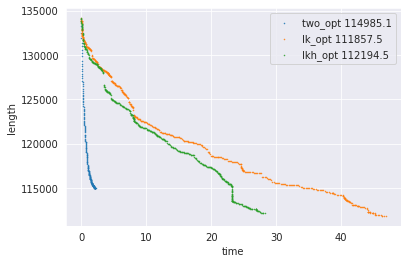

In [9]:
one_test(1500)

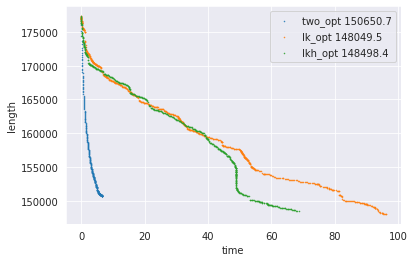

In [10]:
one_test(2000)

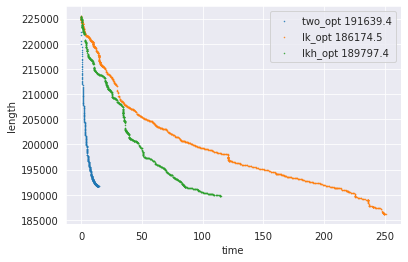

In [11]:
one_test(2500)

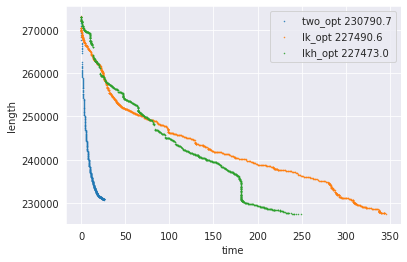

In [12]:
one_test(3000)

## Lin-Kernighan

In [3]:
def runner(optimizer, frame, value, length, tour, matrix, **kwargs):
    t_start = time()
    opt = optimizer(length, tour.copy(), matrix.copy(), **kwargs)
    opt.optimize()
    frame[f'{value}time'].append(time() - t_start)
    frame[f'{value}length'].append(100 - opt.length / (length / 100))
    
def executor(opt, tests, values, parameter, n):
    length_frame = defaultdict(list)
    time_frame = defaultdict(list)
    
    for size in tests:
        frame = defaultdict(list)
        samples = generate_data(size, n)
        for length, tour, matrix in samples:
            for value in values:
                kwargs = {parameter: value}
                runner(opt, frame, value, length, tour, matrix, **kwargs)
        frame = pd.DataFrame(frame)
        for value in values:
            length_frame[f'{parameter}={value}'].append(frame[f'{value}length'].mean())
            time_frame[f'{parameter}={value}'].append(frame[f'{value}time'].mean())
            
    print('-----')
    length_frame = pd.DataFrame(length_frame)
    time_frame = pd.DataFrame(time_frame)
    print('Better then initial (%):') 
    print(length_frame)
    print('Time (s)')
    print(time_frame)  
    
def performance(opter, start, stop, step, iterations=10, **kwargs):
    frame = defaultdict(list)
    for size in range(start, stop + 1, step):
        for _ in range(iterations):
            tsp = generator(size)
            matrix = adjacency_matrix(tsp)
            length, tour = greedy(matrix)
            t_start = time()
            opt = opter(length, tour, matrix, **kwargs)
            opt.optimize()
            frame['time'].append(time() - t_start)
            frame['size'].append(size)
        
    frame = pd.DataFrame(frame)
    return frame

### K-opt
3-opt, 5-opt, 7-opt, 9-opt для Lin-Kernighan

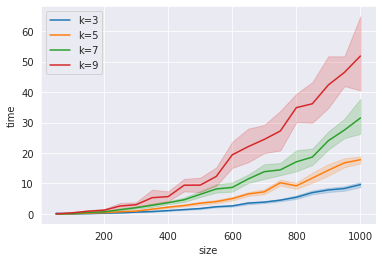

In [51]:
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/LK/LK-opt-50-1000-50-k-3.csv'), label='k=3')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/LK/LK-opt-50-1000-50-k-5.csv'), label='k=5')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/LK/LK-opt-50-1000-50-k-7.csv'), label='k=7')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/LK/LK-opt-50-1000-50-k-9.csv'), label='k=9')

### Neighbours
Количество соседей, используемых в списке кандидатов

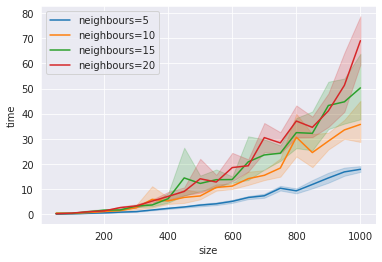

In [52]:
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/LK/LK-opt-50-1000-50-k-5.csv'), label='neighbours=5')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/LK/LK-opt-50-1000-50-n-10.csv'), label='neighbours=10')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/LK/LK-opt-50-1000-50-n-15.csv'), label='neighbours=15')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/LK/LK-opt-50-1000-50-n-20.csv'), label='neighbours=20')

### With / Without: DLB

In [125]:
executor(LKOpt, [25, 50, 100, 200, 400], [True, False], 'dlb', 10)

-----
Better then initial (%):
   dlb=True  dlb=False
0     18.85      18.88
1     17.47      17.81
2     16.52      17.58
3     16.29      17.95
4     16.76      16.43
Time (s)
   dlb=True  dlb=False
0      0.01       0.01
1      0.02       0.03
2      0.08       0.15
3      0.28       0.51
4      1.39       2.41


### With / With Fast / Without: Double Bridge

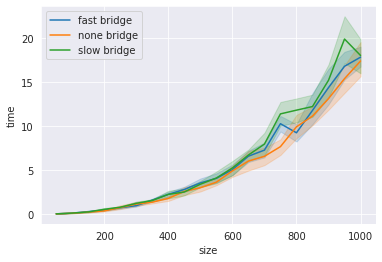

In [53]:
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/LK/LK-opt-50-1000-50-k-5.csv'), label='fast bridge')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/LK/LK-opt-50-1000-50-bridge-none.csv'), label='none bridge')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/LK/LK-opt-50-1000-50-bridge-slow.csv'), label='slow bridge')

## Lin-Kernighan-Helsgaun

### K-opt

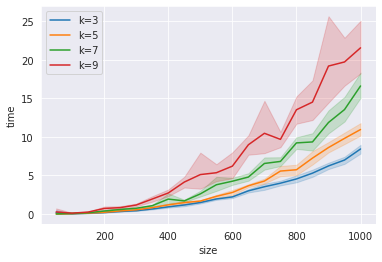

In [54]:
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/LKH/LKH-opt-50-1000-50-k-3.csv'), label='k=3')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/LKH/LKH-opt-50-1000-50-k-5.csv'), label='k=5')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/LKH/LKH-opt-50-1000-50-k-7.csv'), label='k=7')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/LKH/LKH-opt-50-1000-50-k-9.csv'), label='k=9')

### With / Without Subgradient

In [128]:
executor(LKHOpt, [25, 50, 100, 200, 400], [True, False], 'subgradient', 10)

-----
Better then initial (%):
   subgradient=True  subgradient=False
0             12.50              11.55
1             15.22              15.31
2             17.03              17.03
3             17.21              17.07
4             19.05              18.75
Time (s)
   subgradient=True  subgradient=False
0              0.04               0.01
1              0.07               0.04
2              0.28               0.18
3              1.01               0.59
4              4.89               2.81


### Mul for excess
Список кандидатов формируется через параметр alpha: alpha < mul * excess

In [ ]:
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/LKH/LKH-opt-50-1000-50-k-3.csv'), label='mul=1')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/LKH/LKH-opt-50-1000-50-mul-2.csv'), label='mul=2')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/LKH/LKH-opt-50-1000-50-mul-3.csv'), label='mul=3')

### With / Without Non Seq

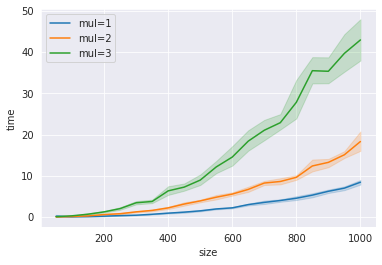

In [57]:
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/LKH/LKH-opt-50-1000-50-k-3.csv'), label='mul=1')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/LKH/LKH-opt-50-1000-50-mul-2.csv'), label='mul=2')
sns.lineplot(x="size", y="time", data=pd.read_csv('./performance/LKH/LKH-opt-50-1000-50-mul-3.csv'), label='mul=3')

### With / Without Non Seq

In [130]:
executor(LKHOpt, [25, 50, 100, 200, 400], [True, False], 'non_seq', 10)

-----
Better then initial (%):
   non_seq=True  non_seq=False
0         13.18          13.18
1         14.90          14.46
2         18.72          18.20
3         18.49          17.91
4         19.23          18.92
Time (s)
   non_seq=True  non_seq=False
0          0.12           0.01
1          0.87           0.04
2          3.98           0.16
3         16.01           0.60
4         54.66           3.24
